In [12]:
import os 
import numpy as np
import re

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from itertools import product

In [13]:
PATH = './models/parameter_search/'

In [14]:
root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy']
npy_files.sort()

In [15]:
len(npy_files)/3

4.0

In [4]:
### run this code to create the parameter file

embedding_dims = [16,32]
latent_dims = [8,16,32]
dropout = [.1,.3,.5]
pooling = ['avg', 'max']
#parameter_grid = list(product(embedding_dims, latent_dims, dropout, pooling))
parameter_grid = list(product(embedding_dims, latent_dims, dropout, pooling))

for npy_file in npy_files:
    numbers = re.findall(r'[\d\.]+',npy_file)
    t = (int(numbers[0]), int(numbers[2]), float(numbers[3]), npy_file[-9:-6])
    if numbers[5] == '3.':
        parameter_grid.remove(t)
with open('./models/parameter_search/parameter_grid.txt', 'wb') as f: 
    np.save(f, np.array(parameter_grid))

In [16]:
# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file[:-6]
        if key not in loss_dict.keys():
            loss_dict[key] = losses
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses))
        

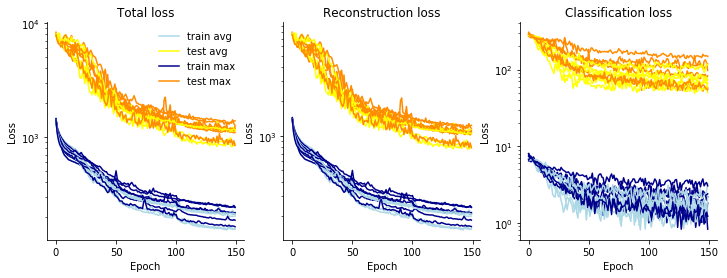

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12,4))
axes = axes.flatten()

titles = ['Total loss', 'Reconstruction loss', 'Classification loss']
for key, item in loss_dict.items():
    
    if key.find('max') > -1:
        c_train = 'darkblue'
        c_val = 'darkorange'
    else:
        c_train = 'lightblue'
        c_val = 'yellow'
        
    #plot mean total training loss
    axes[0].plot(item[:, 0::4].mean(axis=1), c=c_train, label='train')
    # plot mean total validation loss
    axes[0].plot(item[:, 2::4].mean(axis=1), c=c_val, label='validation')
        
    #plot mean reconstruction training loss
    axes[1].plot(item[:, 0::4].mean(axis=1) - item[:, 1::4].mean(axis=1), c=c_train, label='train')
    # plot mean reconstruction validation loss
    axes[1].plot(item[:, 2::4].mean(axis=1) - item[:, 3::4].mean(axis=1), c=c_val, label='validation')
    
    #plot mean classification training loss
    axes[2].plot(item[:, 1::4].mean(axis=1), c=c_train, label='train')
    # plot mean total validation loss
    axes[2].plot(item[:, 3::4].mean(axis=1), c=c_val, label='validation')
    
for k, ax in enumerate(axes): 
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.set_title(titles[k])
sns.despine()
legend_handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(legend_handles[:4], ['train avg', 'test avg', 'train max', 'test max'], frameon=False)

In [25]:
best_val_loss = np.infty
best_model = ''

for key, item in loss_dict.items():
    
    min_val_loss = np.min(item[:, 2::4].mean(axis=1))
    if min_val_loss < best_val_loss:
        best_val_loss = min_val_loss
        best_model = key
print('Model %s has the best validation loss of '%best_model, np.round(best_val_loss, 4))

Model losses_emb32_hid32_lat32_dp0.5_k500_avg has the best validation loss of  820.9666


In [26]:
import re
import pandas as pd

In [27]:
min_loss_dict = {'emb': [], 'hid': [], 'lat': [], 'dropout': [], 'kappa': [], 'pool': [], 
                'min_loss': [], 'loss_std': []}
for key, item in loss_dict.items():
    
    mean_val_loss = item[:, 2::4].mean(axis=1)
    min_ix = np.argmin(mean_val_loss)
    min_val_loss = mean_val_loss[min_ix]
    
    std_val_loss = item[:, 2::4].std(axis=1)
    
    numbers = re.findall(r'\d+', key) 
    min_loss_dict['emb'] += [int(numbers[0])]
    min_loss_dict['hid'] += [int(numbers[1])]
    min_loss_dict['lat'] += [int(numbers[2])]
    min_loss_dict['dropout'] += [float('.'.join(numbers[3:5]))]
    min_loss_dict['kappa'] += [int(numbers[5])]
    min_loss_dict['pool'] += [key[-3:]]
    
    min_loss_dict['min_loss'] += [min_val_loss]
    min_loss_dict['loss_std'] += [std_val_loss[min_ix]]
df = pd.DataFrame(min_loss_dict)

In [28]:
df.groupby(['emb', 'hid', 'lat', 'dropout', 'kappa', 'pool']).mean()


min_loss  loss_std
emb hid lat dropout kappa pool                       
16  16  8   0.1     500   avg    882.018125       0.0
                          max   1088.448500       0.0
            0.3     500   avg   1117.640375       0.0
                          max   1130.552000       0.0
            0.5     500   avg   1143.612000       0.0
                          max   1300.254625       0.0
        16  0.5     500   avg   1109.223000       0.0
                          max   1262.056500       0.0
        32  0.5     500   avg   1168.402000       0.0
                          max   1145.551875       0.0
32  32  32  0.5     500   avg    820.966563       0.0
                          max    843.517438       0.0

ValueError: shape mismatch: objects cannot be broadcast to a single shape

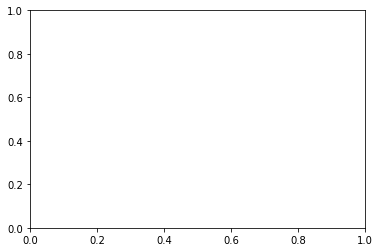

In [29]:
emb16_df = df[df['emb'] == 16].sort_values(['lat', 'dropout', 'pool'])
#emb32_df = df[df['emb'] == 32].sort_values(['lat', 'dropout', 'pool'])
plt.errorbar(x=range(4), y=emb16_df['min_loss'], yerr=2*emb16_df['loss_std'], label='emb=16')
#plt.errorbar(x=range(24), y=emb32_df['min_loss'], yerr=2*emb32_df['loss_std'], label='emb=32')
#sns.despine()
#plt.legend(frameon=False)

In [ ]:
emb16_df['min_loss']

In [ ]:
sns.set(font_scale=1.3)
sns.set_style('ticks')

In [ ]:
plt.figure(figsize=(4,4))
best_run_max = loss_dict['losses_emb32_hid32_lat32_dp0.1_k500_max']

rec_loss = best_run_max[:,0::2] - best_run_max[:,1::2] 

plt.plot(rec_loss[:,1::2].mean(axis=1), c='k', label='rec')
plt.fill_between(range(150), 
                 rec_loss[:,1::2].mean(axis=1) - rec_loss[:,1::2].std(axis=1), 
                 rec_loss[:,1::2].mean(axis=1) + rec_loss[:,1::2].std(axis=1), 
                alpha=.3, color='k')

plt.plot(best_run_max[:,3::4].mean(axis=1), '--', c='k', label='class')
plt.fill_between(range(150), 
                 best_run_max[:,3::4].mean(axis=1) - best_run_max[:,3::4].std(axis=1), 
                 best_run_max[:,3::4].mean(axis=1) + best_run_max[:,3::4].std(axis=1), 
                alpha=.3, color='k', label='val')


plt.plot(rec_loss[:,0::2].mean(axis=1), c='grey')
plt.fill_between(range(150), 
                 rec_loss[:,0::2].mean(axis=1) - rec_loss[:,0::2].std(axis=1), 
                 rec_loss[:,0::2].mean(axis=1) + rec_loss[:,0::2].std(axis=1), 
                alpha=.3, color='grey', label='train')


plt.plot(best_run_max[:,1::4].mean(axis=1), '--', c='grey')
plt.fill_between(range(150), 
                 best_run_max[:,1::4].mean(axis=1) - best_run_max[:,1::4].std(axis=1), 
                 best_run_max[:,1::4].mean(axis=1) + best_run_max[:,1::4].std(axis=1), 
                alpha=.3, color='grey')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().set_yscale('log')
sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(.7,.8))
plt.tight_layout()
plt.savefig('./pics/ICML/v5/Fig3/best_model_losses.svg', format='svg')

In [ ]:
with open('./models/classification_analysis/amountOfLabels.txt', 'rb') as f:
    l = np.load(f)
l

In [ ]:
l = np.array([1.,0.9, 0.8 ,.7, .6,.5, 0.4 , 0.3 , 0.2 , 0.15, 0.1 , 0.05, 0.])
with open('./models/classification_analysis/amountOfLabels.txt', 'wb') as f:
    np.save(f, l)